In [1]:
import libsumo as traci
import time
import csv
import os
import random, numpy as np
import pandas as pd, matplotlib.pyplot as plt
import csv, os
from datetime import datetime
from src import config

random.seed(config.SEED)
np.random.seed(config.SEED)

## Simulation Section

In [2]:
from src.simulation_libs import find_avg_halt_range;
from src import config
from src import road_config

sumoCmd = [
    config.SUMO_BINARY,
    "-c", config.SUMO_CFG,
    "--seed", str(config.SEED),
]
traci.start(sumoCmd)
print(traci.trafficlight.getControlledLanes(road_config.TL_ID))
traci.simulationStep()
traci.simulation.saveState(config.SUMO_FIRST_STATE)
signal_state = traci.trafficlight.getRedYellowGreenState(road_config.TL_ID)
print(signal_state)

(max_avg_halt,min_avg_halt,max_fairness,min_fairness) = find_avg_halt_range(road_config.NS_LANES, road_config.EW_LANES)
print('Max avg halt', max_avg_halt)
print('Min avg halt', min_avg_halt)
print('Max fairness', max_fairness)
print('Min fairness', min_fairness)
traci.close()

('1265822568#3_0', '1265822568#3_0', '1265822568#3_1', '1265822568#3_2', '1265822568#3_2', '1200728225#1_0', '1200728225#1_1', '1200728225#1_1', '1200728225#1_1', '1221994726#0_0', '1221994726#0_0', '1221994726#0_1')
rrrrrGGggGGG
❌ Stopping at END_TIME.
Max avg halt 21.615384615384617
Min avg halt 2.5
Max fairness 0.8070175350107727
Min fairness 0.0026881720068794085


# Running Simulation with optimzied results

In [ ]:
from src.de_experiment import seed_de_simulation
# Run the function
seed_de_simulation()

# Running Simulation with optimzied results and store input/output for MLP training

In [13]:
from src.de_experiment import seed_de_teacher_simulation
import time

# Run the function 5 times
for i in range(5):
    print(f"Run {i+1}/5")
    try:
        seed_de_teacher_simulation()
    except Exception as e:
        print(f"Error on run {i+1}: {e}")
        break
    time.sleep(10)  # Optional: wait a bit between runs

Chosen split=0.60, C=108.5, O1=0.257, O2=0.020, score=0.186, time=65.29s, gen=8

Time passed at cycle 126: 9887.0s.
=== Cycle 126 (t=9887.0s) ===
Early stopping: time lapsed 60.3026557550038s
Chosen split=0.61, C=108.4, O1=0.324, O2=0.028, score=0.235, time=60.30s, gen=7

Time passed at cycle 127: 9995.0s.
=== Cycle 127 (t=9995.0s) ===
Early stopping: time lapsed 63.06246253500285s
Chosen split=0.66, C=74.2, O1=0.261, O2=0.008, score=0.185, time=63.06s, gen=7

Time passed at cycle 128: 10069.0s.
=== Cycle 128 (t=10069.0s) ===
Early stopping: score std 0.000000 < 0.0001
Chosen split=0.68, C=74.2, O1=0.260, O2=0.010, score=0.185, time=62.36s, gen=6

Time passed at cycle 129: 10143.0s.
=== Cycle 129 (t=10143.0s) ===
Early stopping: time lapsed 62.00788947100227s
Chosen split=0.67, C=68.8, O1=0.210, O2=0.037, score=0.158, time=62.01s, gen=6

Time passed at cycle 130: 10211.0s.
=== Cycle 130 (t=10211.0s) ===
Early stopping: score std 0.000000 < 0.0001
Chosen split=0.62, C=66.9, O1=0.269, O2

In [ ]:
from src.de_experiment import seed_de_teacher_simulation
# # Run the function
seed_de_teacher_simulation()

Loaded 196 cycles from logs/traffic_DE_summary_20251203_100700.csv


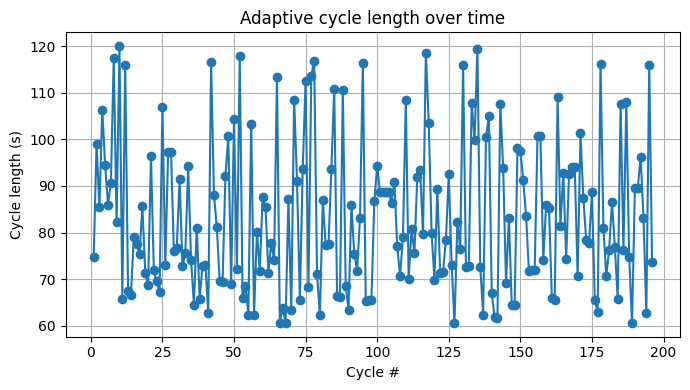

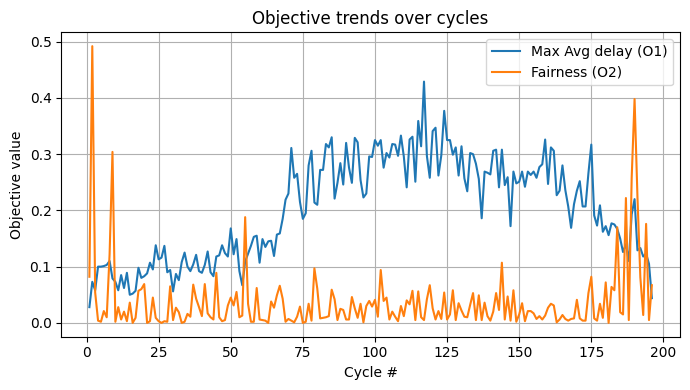

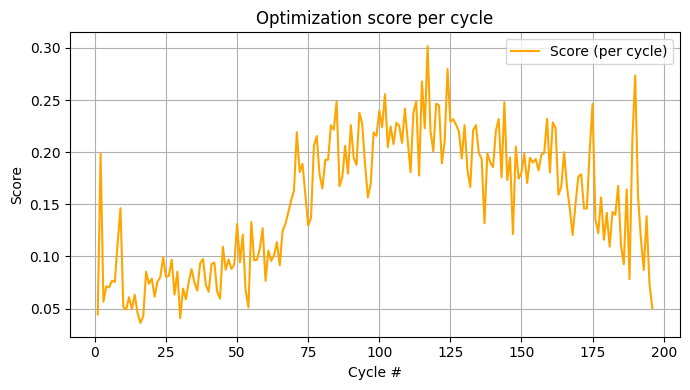

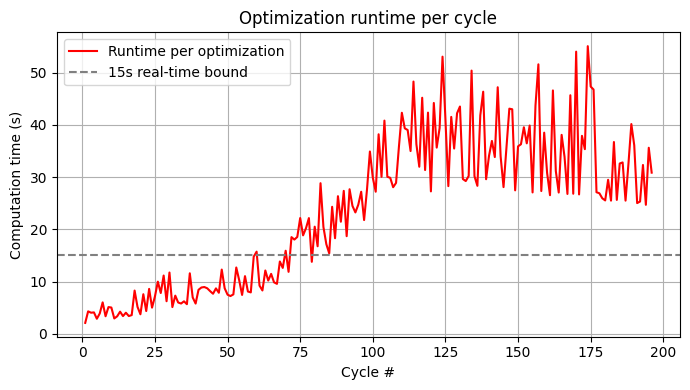


=== Summary statistics ===
             s        C       O1       O2  score_best  elapsed_s
count  196.000  196.000  196.000  196.000     196.000    196.000
mean     0.585   83.366    0.203    0.036       0.153     23.461
std      0.074   16.091    0.090    0.061       0.063     14.051
min      0.351   60.600    0.028    0.000       0.036      2.090
25%      0.534   70.700    0.119    0.006       0.094      8.835
50%      0.590   79.750    0.212    0.017       0.164     25.600
75%      0.645   93.725    0.278    0.044       0.205     34.942
max      0.687  120.000    0.429    0.492       0.302     55.100

✅  Average runtime per DE optimization: 23.46s
✅ Visualization complete — core PoW evidence generated.


In [3]:
from src import config
from src.utils import visualize_pow_results

visualize_pow_results(log_dir=config.LOG_DIR, suffix="20251203_100700")

In [2]:
from src.de_experiment import baseline_simulation

baseline_simulation()

Running baseline simulation: s=0.5, C=90s for 300 cycles

Time passed at cycle 1: 1.0s.
=== Cycle 1 (t=1.0s) ===
Vehicles currently in simulation: 1
Fixed split=0.50, C=90.0, O1=0.089, O2=0.583, score=0.238

Time passed at cycle 2: 91.0s.
=== Cycle 2 (t=91.0s) ===
Vehicles currently in simulation: 19
Fixed split=0.50, C=90.0, O1=0.104, O2=0.165, score=0.122

Time passed at cycle 3: 181.0s.
=== Cycle 3 (t=181.0s) ===
Vehicles currently in simulation: 16
Fixed split=0.50, C=90.0, O1=0.087, O2=0.094, score=0.089

Time passed at cycle 4: 271.0s.
=== Cycle 4 (t=271.0s) ===
Vehicles currently in simulation: 22
Fixed split=0.50, C=90.0, O1=0.117, O2=0.137, score=0.123

Time passed at cycle 5: 361.0s.
=== Cycle 5 (t=361.0s) ===
Vehicles currently in simulation: 23
Fixed split=0.50, C=90.0, O1=0.118, O2=0.201, score=0.143

Time passed at cycle 6: 451.0s.
=== Cycle 6 (t=451.0s) ===
Vehicles currently in simulation: 21
Fixed split=0.50, C=90.0, O1=0.124, O2=0.143, score=0.130

Time passed at cycl

Loaded 180 cycles from logs/traffic_baseline_summary_20251203_135153.csv


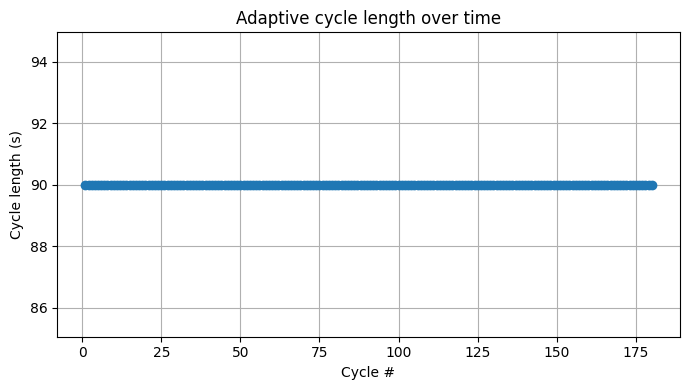

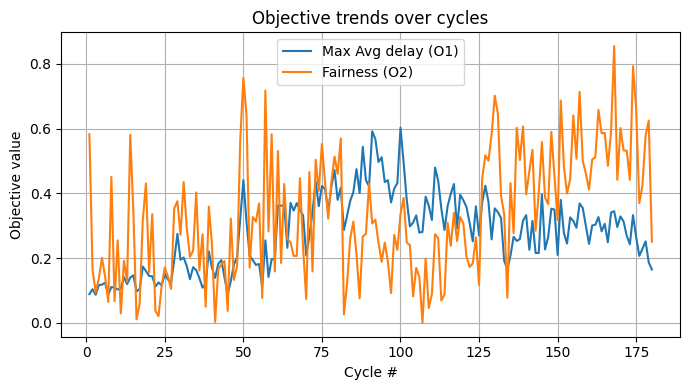

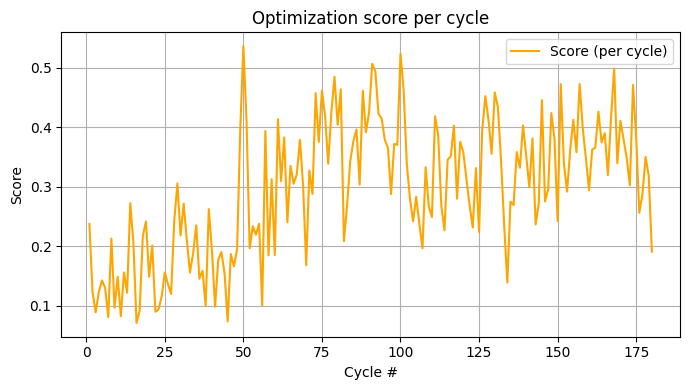

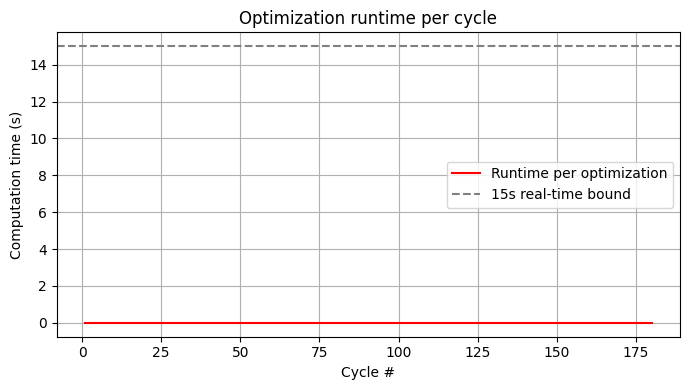


=== Summary statistics ===
           s      C       O1       O2  score_best  elapsed_s
count  180.0  180.0  180.000  180.000     180.000      180.0
mean     0.5   90.0    0.280    0.333       0.296        0.0
std      0.0    0.0    0.117    0.191       0.113        0.0
min      0.5   90.0    0.087    0.000       0.071        0.0
25%      0.5   90.0    0.182    0.183       0.210        0.0
50%      0.5   90.0    0.285    0.316       0.303        0.0
75%      0.5   90.0    0.362    0.466       0.382        0.0
max      0.5   90.0    0.603    0.855       0.536        0.0

✅  Average runtime per DE optimization: 0.00s
✅ Visualization complete — core PoW evidence generated.


In [3]:
from src import config
from src.utils import visualize_pow_results

visualize_pow_results(log_dir=config.LOG_DIR, prefix="traffic_baseline", suffix="20251203_135153")

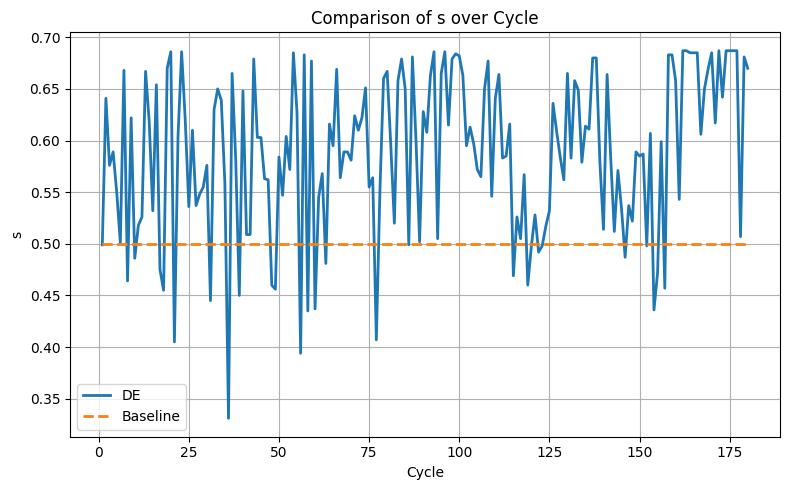

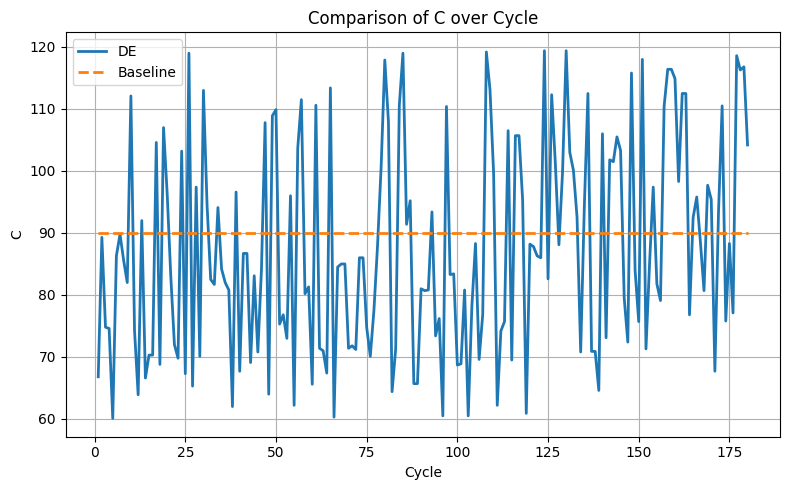

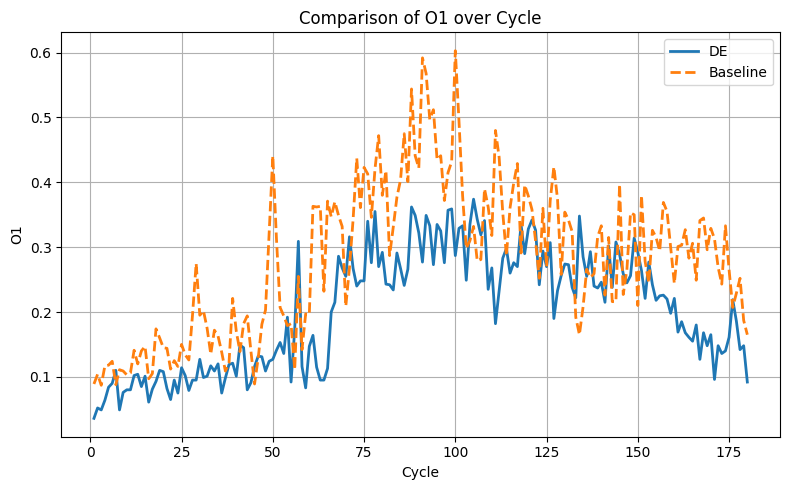

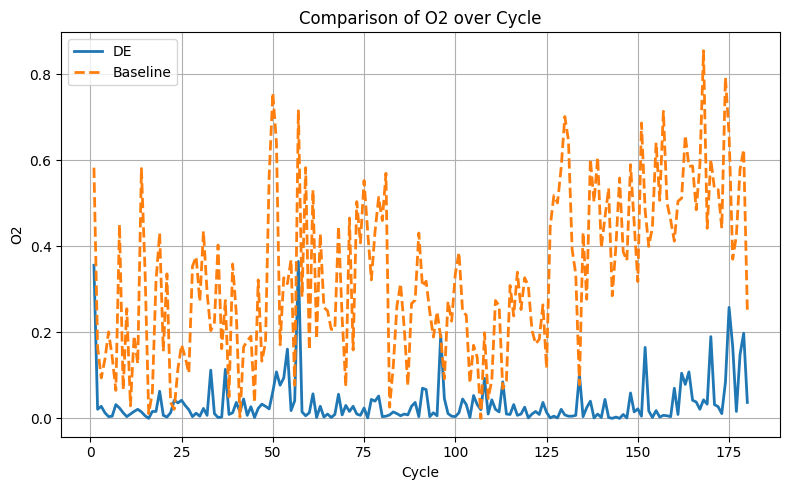

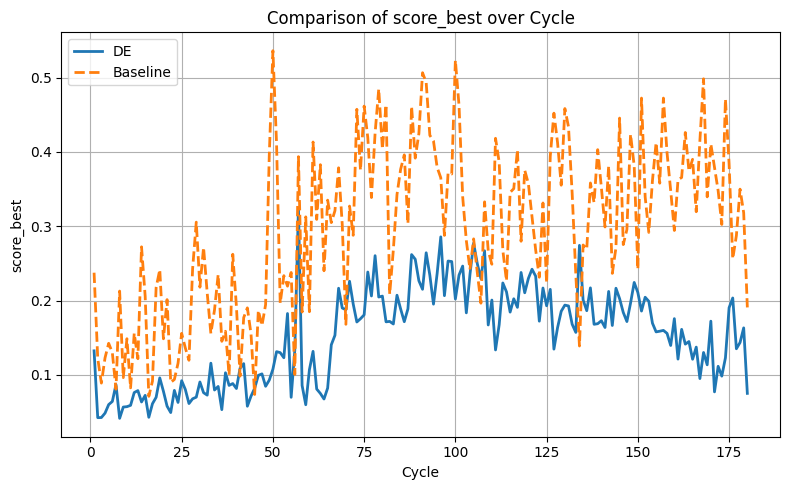

In [4]:
from src.utils import compare_logs_by_time

compare_logs_by_time(de_suffix='20251205_081349', baseline_suffix='20251203_135153')

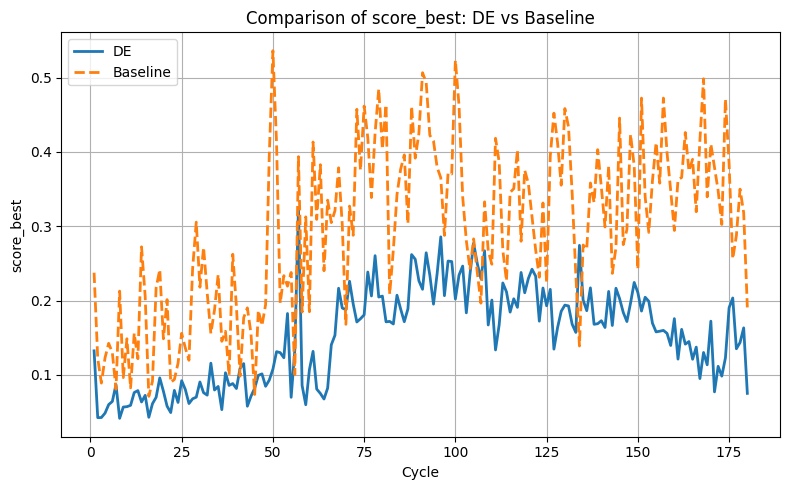

Average DE score_best: 0.1520
Average Baseline score_best: 0.2956
Δ Improvement: -0.1436 (-48.58% change)
✅ DE improves over Baseline.


In [5]:
from src.utils import compare_score_best

compare_score_best(de_suffix='20251205_081349', baseline_suffix='20251203_135153')